# WiDS Datathon 2026 Notebook
This is where your analysis begins. Use this notebook for EDA, modeling, and explanations.

## **INTRODUCERE**
**CONTEXT:** Setul de date utilizat conține informații despre incidente de tip wildfire, semnale operaționale de risc (ex. radio traffic, spotting, amenințări asupra structurilor), actualizări publice și informații despre evacuări. Datele reflectă modul în care riscul este detectat la nivel operațional și modul în care acesta este comunicat către populație, oferind oportunitatea de a analiza întârzierile dintre apariția riscului și emiterea alertelor de evacuare.

În contextul schimbărilor climatice și al intensificării incendiilor de vegetație, timpii de reacție și comunicare joacă un rol esențial în protejarea comunităților, în special a celor vulnerabile. Acest proiect se aliniază temei WiDS Datathon 2026 – Route 1: Accelerating Equitable Evacuations, concentrându-se pe analiza echității și promptitudinii alertelor de evacuare.

**OBIECTIVE:**


*   Analiza întârzierilor de alertare (alert lag) dintre primul semnal operațional de risc și momentul în care informația devine publică
*   Identificarea tipurilor de semnale care conduc la cele mai mari întârzieri
*   Construirea unui scor de declanșare a riscului (Risk Trigger Score), explicabil și bazat pe date, pentru detectarea situațiilor care ar fi necesitat alertare proactivă
*   Evaluarea alertelor ratate, respectiv a incidentelor cu risc ridicat care nu au generat avertismente de evacuare
*   Propunerea unei abordări proactive pentru îmbunătățirea sistemelor de alertare, cu potențial impact asupra echității și siguranței comunităților

**SURSA DATELOR:** https://www.kaggle.com/competitions/wids-university-datathon-2025/data

**Echipa** ***Core6*** :


*   Ceau Robert-Vasile
*   Constantin Teodor-Vasile
*   Erhan Teodora-Miruna
*   Lazăr Diana-Maria
*   Mărian Ruxandra-Elena
*   Nițu Vlad-Cristian











In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"marianruxandraelena","key":"d555c8c19d5748d1c2da4888fc6b6613"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c wids-university-datathon-2025

 94% 378M/403M [00:01<00:00, 166MB/s]
100% 403M/403M [00:02<00:00, 207MB/s]


In [5]:
!unzip wids-university-datathon-2025.zip -d data/

Archive:  wids-university-datathon-2025.zip
  inflating: data/WiDS _-_ Watch Duty_ Data Dictionary.docx  
  inflating: data/evac_zone_status_geo_event_map.csv  
  inflating: data/evac_zones_gis_evaczone.csv  
  inflating: data/evac_zones_gis_evaczonechangelog.csv  
  inflating: data/fire_perimeters_gis_fireperimeter.csv  
  inflating: data/fire_perimeters_gis_fireperimeterchangelog.csv  
  inflating: data/geo_events_externalgeoevent.csv  
  inflating: data/geo_events_externalgeoeventchangelog.csv  
  inflating: data/geo_events_geoevent.csv  
  inflating: data/geo_events_geoeventchangelog.csv  


In [6]:
!ls data

 evac_zones_gis_evaczonechangelog.csv
 evac_zones_gis_evaczone.csv
 evac_zone_status_geo_event_map.csv
 fire_perimeters_gis_fireperimeterchangelog.csv
 fire_perimeters_gis_fireperimeter.csv
 geo_events_externalgeoeventchangelog.csv
 geo_events_externalgeoevent.csv
 geo_events_geoeventchangelog.csv
 geo_events_geoevent.csv
'WiDS _-_ Watch Duty_ Data Dictionary.docx'


## **Importul librăriilor necesare și încărcarea seturilor de date utilizate**

In [25]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
geo = pd.read_csv("data/geo_events_geoevent.csv", parse_dates=["date_created", "date_modified"])
geo_changelog = pd.read_csv("data/geo_events_geoeventchangelog.csv", parse_dates=["date_created"])
map_event_zone = pd.read_csv("data/evac_zone_status_geo_event_map.csv")


In [26]:
# păstrăm DOAR incendiile
geo = geo[geo["geo_event_type"] == "wildfire"].copy()

# redenumire ID
geo = geo.rename(columns={"id": "geo_event_id"})


In [27]:
def extract_json(js, key):
    if not isinstance(js, str) or "{" not in js:
        return np.nan
    try:
        d = json.loads(js.strip('"'))
        return d.get(key, np.nan)
    except:
        return np.nan

json_fields = [
    "containment",
    "acreage",
    "is_fps",
    "is_prescribed",
    "evacuation_orders",
    "evacuation_warnings"
]

for col in json_fields:
    geo[col] = geo["data"].apply(lambda x: extract_json(x, col))

geo.drop(columns=["data"], inplace=True)

# tipuri corecte
geo["containment"] = pd.to_numeric(geo["containment"], errors="coerce")
geo["acreage"] = pd.to_numeric(geo["acreage"], errors="coerce")
geo["is_fps"] = geo["is_fps"].astype("boolean")
geo["is_prescribed"] = geo["is_prescribed"].astype("boolean")

cols_to_drop = [
    "name", "description", "address",
    "external_source", "incident_id",
    "reported_managed", "is_visible"
]

geo = geo.drop(
    columns=[c for c in cols_to_drop if c in geo.columns]
)


In [28]:
geo.head()

,geo_event_id,date_created,date_modified,geo_event_type,is_active,lat,lng,notification_type,external_id,reporter_managed,containment,acreage,is_fps,is_prescribed,evacuation_orders,evacuation_warnings
0,76,2021-08-11 00:09:56.481066,2023-02-09 20:34:24.180117,wildfire,0,38.386100,-122.769299,normal,1008375748,1,100.0,50.0,False,False,None,None
1,77,2021-08-11 07:21:46.054995,2023-02-09 20:34:24.225186,wildfire,0,38.459967,-122.728927,normal,1008583077,1,100.0,0.0,False,False,None,None
2,78,2021-08-11 21:02:16.301416,2023-02-09 20:34:24.266124,wildfire,0,38.318328,-122.925698,normal,1008957703,1,0.0,0.0,False,False,None,None
3,79,2021-08-12 01:46:31.043052,2023-02-09 20:34:24.308048,wildfire,0,38.479988,-122.994156,normal,1009152928,1,0.0,0.0,False,False,None,None
4,80,2021-08-12 02:40:30.939331,2023-02-09 20:34:24.358582,wildfire,0,38.315222,-122.276532,normal,1009187142,1,100.0,0.0,False,False,None,None


#####**Crearea unei variabile binare care indică dacă un incident prezintă semnale operaționale ce pot preceda agravarea situației și necesitatea alertării populației.**

In [29]:
def has_risk_signal(changes):
    if not isinstance(changes, str):
        return False
    text = changes.lower()
    return any(k in text for k in [
        "radio_traffic",
        "spotting",
        "structure_threat",
        "rate_of_spread"
    ])

geo_changelog["risk_signal"] = geo_changelog["changes"].apply(has_risk_signal)


#####**Identificarea celui mai timpuriu moment în care apare un semnal operațional de risc, definind astfel momentul inițial al potențialului pericol.**

In [30]:
first_risk = (
    geo_changelog[geo_changelog["risk_signal"]]
    .groupby("geo_event_id")["date_created"]
    .min()
    .reset_index()
    .rename(columns={"date_created": "first_risk_time"})
)


In [31]:
geo = geo.merge(first_risk, on="geo_event_id", how="left")
geo["first_risk_time"]

,first_risk_time
0,NaT
1,NaT
2,NaT
3,NaT
4,NaT
...,...
61774,NaT
61775,NaT
61776,NaT
61777,NaT


In [32]:
# Forțăm toate datetime-urile relevante să fie UTC tz-aware
geo["date_modified"] = pd.to_datetime(
    geo["date_modified"], utc=True, errors="coerce"
)

geo["date_created"] = pd.to_datetime(
    geo["date_created"], utc=True, errors="coerce"
)

geo["first_risk_time"] = pd.to_datetime(
    geo["first_risk_time"], utc=True, errors="coerce"
)


#####**Calcularea întârzierii (în minute) dintre primul semnal de risc și momentul actualizării publice a incidentului, eliminând valorile imposibile pentru a asigura rezultate realiste.**

In [33]:
geo["risk_to_update_min"] = (
    (geo["date_modified"] - geo["first_risk_time"])
    .dt.total_seconds() / 60
)

# curățare valori imposibile
geo = geo[
    (geo["risk_to_update_min"].isna()) |
    ((geo["risk_to_update_min"] >= 0) & (geo["risk_to_update_min"] <= 7*24*60))
]


#####**Marcarea incidentelor pentru care întârzierea dintre apariția riscului și actualizarea publică depășește pragul de 3 ore, indicând cazuri cu potențial de comunicare întârziată.**

In [34]:
DELAY_THRESHOLD_MIN = 180  # 3 ore

geo["is_delayed"] = geo["risk_to_update_min"] > DELAY_THRESHOLD_MIN


## **ANALIZA EXPLORATORIE**

*   Aproximativ 55.000 incidente (90%) au is_delayed = False -> în general, actualizările publice apar într-un interval considerat acceptabil
*   Aproximativ 6.000–6.500 incidente (10%) sunt marcate cu is_delayed = True -> depășesc pragul de 3 ore dintre primul semnal de risc și actualizarea publică






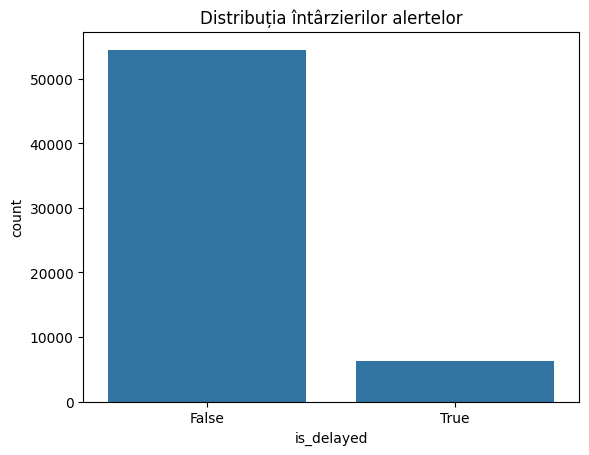

In [39]:
# Distribuția întârzierii alertelor
sns.countplot(x="is_delayed", data=geo)
plt.title("Distribuția întârzierilor alertelor")
plt.show()


*   Distribuție puternic asimetrică (right-skewed)
*   Majoritatea incidentelor au întârzieri mici, concentrate în primele 0–200 minute
*   Coadă lungă de valori extreme
*   Există incidente cu întârzieri de peste 1.000–10.000 de minute (zile întregi)






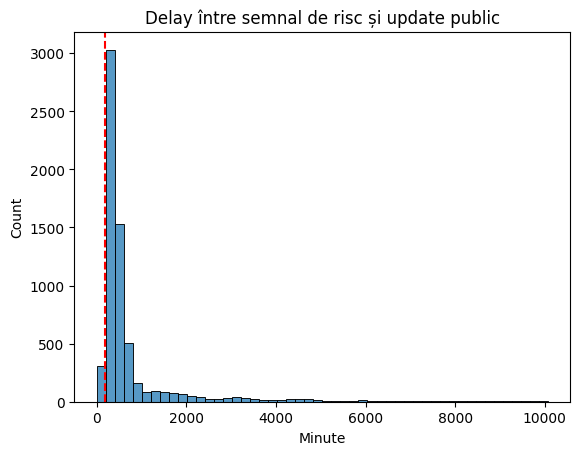

In [40]:
# Distribuția întârzierii dintre semnalul de risc și actualizarea publică
sns.histplot(geo["risk_to_update_min"].dropna(), bins=50)
plt.axvline(180, color="red", linestyle="--")
plt.title("Delay între semnal de risc și update public")
plt.xlabel("Minute")
plt.show()


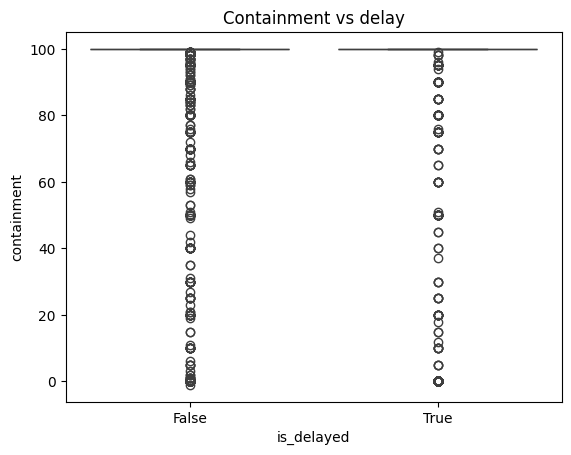

In [41]:
sns.boxplot(x="is_delayed", y="containment", data=geo)
plt.title("Containment vs delay")
plt.show()


*   Atât incidentele întârziate, cât și cele neîntârziate prezintă o variație largă a valorilor de containment (0–100%)
*   Multe incidente marcate ca întârziate au niveluri scăzute sau medii de containere
*   Întârzierile în comunicarea publică nu sunt explicate exclusiv de nivelul de containere al incendiului
*   Rezultatul indică necesitatea utilizării semnalelor operaționale timpurii, nu doar a indicatorilor de stare curentă




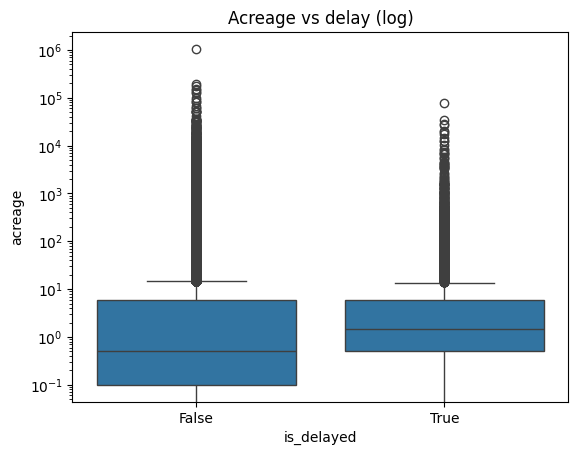

In [42]:
sns.boxplot(x="is_delayed", y="acreage", data=geo)
plt.yscale("log")
plt.title("Acreage vs delay (log)")
plt.show()


**Distribuția pe ore**
*   Incidentele sunt mai frecvente în a doua parte a zilei, cu un vârf între orele 16–22
*   Frecvența scade semnificativ în intervalul 6–11 dimineața

**Distribuția pe zile ale săptămânii**
*   Evenimentele sunt relativ uniform distribuite pe parcursul săptămânii
*   Se observă o ușoară scădere în zilele de weekend (ziua 5 și 6)

**Distribuția pe luni**
*   Incidentele sunt concentrate în lunile de vară, cu un maxim în iunie–august
*   Frecvența scade semnificativ în lunile de iarnă

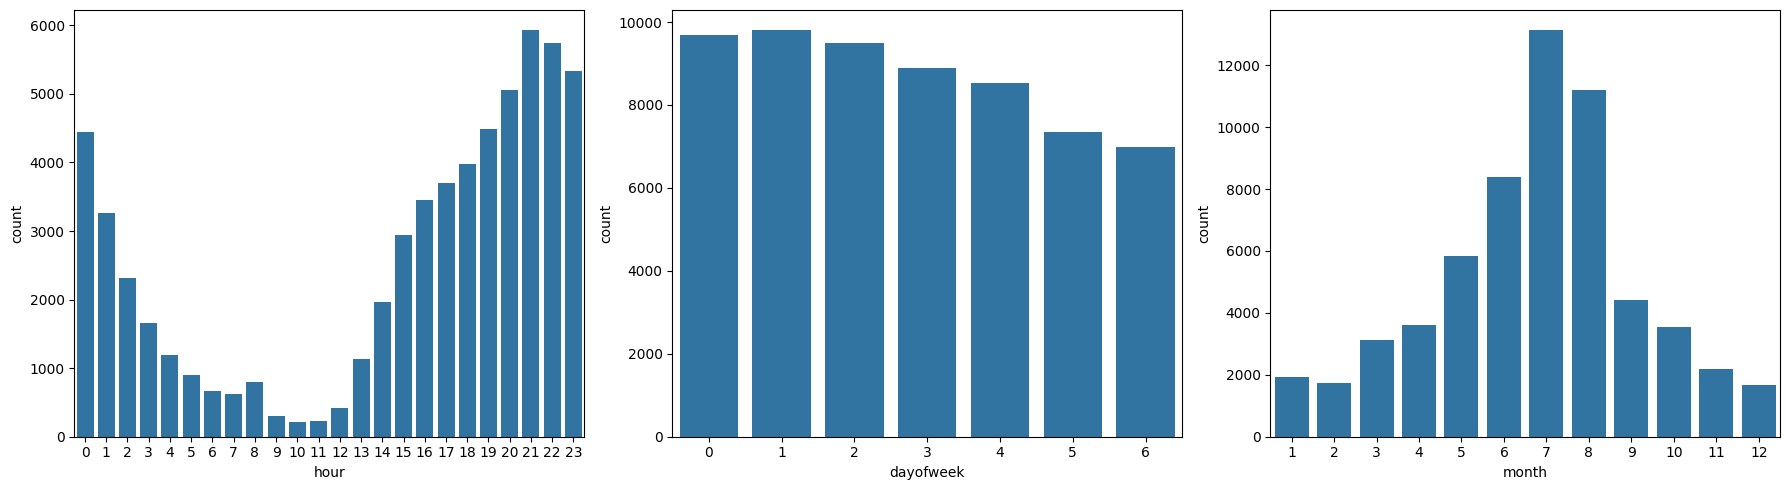

In [43]:
geo["hour"] = geo["date_created"].dt.hour
geo["dayofweek"] = geo["date_created"].dt.dayofweek
geo["month"] = geo["date_created"].dt.month

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.countplot(x="hour", data=geo, ax=axes[0])
sns.countplot(x="dayofweek", data=geo, ax=axes[1])
sns.countplot(x="month", data=geo, ax=axes[2])
plt.tight_layout()
plt.show()


In [44]:
# Variabile binare: există ordin / avertisment de evacuare?
geo["has_evac_order"] = geo["evacuation_orders"].notna() & (geo["evacuation_orders"] != "")
geo["has_evac_warning"] = geo["evacuation_warnings"].notna() & (geo["evacuation_warnings"] != "")

# Convertim la 0 / 1
geo["has_evac_order"] = geo["has_evac_order"].astype(int)
geo["has_evac_warning"] = geo["has_evac_warning"].astype(int)


In [45]:
# Alegem coloanele utile pentru model (doar numerice!)
feature_cols = [
    "containment", "acreage",
    "is_fps", "is_prescribed",
    "has_evac_order", "has_evac_warning",
    "hour", "dayofweek", "month"
]


In [46]:
# Facem o copie curată
df_model = geo.copy()

# Ne asigurăm că toate coloanele sunt numerice
df_model["is_fps"] = df_model["is_fps"].fillna(False).astype(int)
df_model["is_prescribed"] = df_model["is_prescribed"].fillna(False).astype(int)

# Eliminăm rândurile fără etichetă sau valori lipsă în features
df_model = df_model.dropna(subset=feature_cols + ["is_delayed"])

# Definim X și y
X = df_model[feature_cols]
y = df_model["is_delayed"].astype(int)



In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Standardizăm doar feature-urile, nu și eticheta
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Împărțim în train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)


In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:35:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [49]:
models = {
    "Logistic Regression": (y_pred_lr, y_prob_lr),
    "Random Forest": (y_pred_rf, y_prob_rf),
    "XGBoost": (y_pred_xgb, y_prob_xgb)
}

for name, (y_pred, y_prob) in models.items():
    print("="*60)
    print(f"🔹 Rezultate pentru: {name}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))
    print("ROC-AUC Score:", round(roc_auc_score(y_test, y_prob), 4))


🔹 Rezultate pentru: Logistic Regression
Confusion Matrix:
[[6042  160]
 [ 476  236]]

Classification Report:
              precision    recall  f1-score   support

           0      0.927     0.974     0.950      6202
           1      0.596     0.331     0.426       712

    accuracy                          0.908      6914
   macro avg      0.761     0.653     0.688      6914
weighted avg      0.893     0.908     0.896      6914

ROC-AUC Score: 0.6761
🔹 Rezultate pentru: Random Forest
Confusion Matrix:
[[5913  289]
 [ 533  179]]

Classification Report:
              precision    recall  f1-score   support

           0      0.917     0.953     0.935      6202
           1      0.382     0.251     0.303       712

    accuracy                          0.881      6914
   macro avg      0.650     0.602     0.619      6914
weighted avg      0.862     0.881     0.870      6914

ROC-AUC Score: 0.7857
🔹 Rezultate pentru: XGBoost
Confusion Matrix:
[[6071  131]
 [ 536  176]]

Classification R

In [50]:
pip install imbalanced-learn


SMOTE echilibrează setul de antrenare prin supra-eșantionarea clasei minoritare (is_delayed = 1)

Obiectivul principal este creșterea recall-ului pentru incidentele întârziate, chiar cu costul scăderii acurateții globale

In [51]:
from imblearn.over_sampling import SMOTE
import numpy as np

# Aplicăm SMOTE pe setul de antrenare
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Verificare distribuție
print("Distribuție după SMOTE:", np.bincount(y_resampled))


Distribuție după SMOTE: [14470 14470]


In [52]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_resampled, y_resampled)
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=None)  # Fără 'balanced' acum!
rf.fit(X_resampled, y_resampled)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_resampled, y_resampled)
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:38:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [53]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

models = {
    "Logistic Regression (SMOTE)": (y_pred_lr, y_prob_lr),
    "Random Forest (SMOTE)": (y_pred_rf, y_prob_rf),
    "XGBoost (SMOTE)": (y_pred_xgb, y_prob_xgb)
}

for name, (y_pred, y_prob) in models.items():
    print("="*60)
    print(f"🔹 Rezultate pentru: {name}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))
    print("ROC-AUC Score:", round(roc_auc_score(y_test, y_prob), 4))


🔹 Rezultate pentru: Logistic Regression (SMOTE)
Confusion Matrix:
[[5726  476]
 [ 432  280]]

Classification Report:
              precision    recall  f1-score   support

           0      0.930     0.923     0.927      6202
           1      0.370     0.393     0.381       712

    accuracy                          0.869      6914
   macro avg      0.650     0.658     0.654      6914
weighted avg      0.872     0.869     0.870      6914

ROC-AUC Score: 0.6728
🔹 Rezultate pentru: Random Forest (SMOTE)
Confusion Matrix:
[[5585  617]
 [ 432  280]]

Classification Report:
              precision    recall  f1-score   support

           0      0.928     0.901     0.914      6202
           1      0.312     0.393     0.348       712

    accuracy                          0.848      6914
   macro avg      0.620     0.647     0.631      6914
weighted avg      0.865     0.848     0.856      6914

ROC-AUC Score: 0.7788
🔹 Rezultate pentru: XGBoost (SMOTE)
Confusion Matrix:
[[5547  655]
 [ 413 

Modelele non-liniare beneficiază mai mult de echilibrarea datelor prin SMOTE

Diferențele între curbe susțin utilizarea XGBoost ca model principal pentru scoruri de risc

Curba ROC confirmă că informația din semnalele de risc are valoare predictivă reală

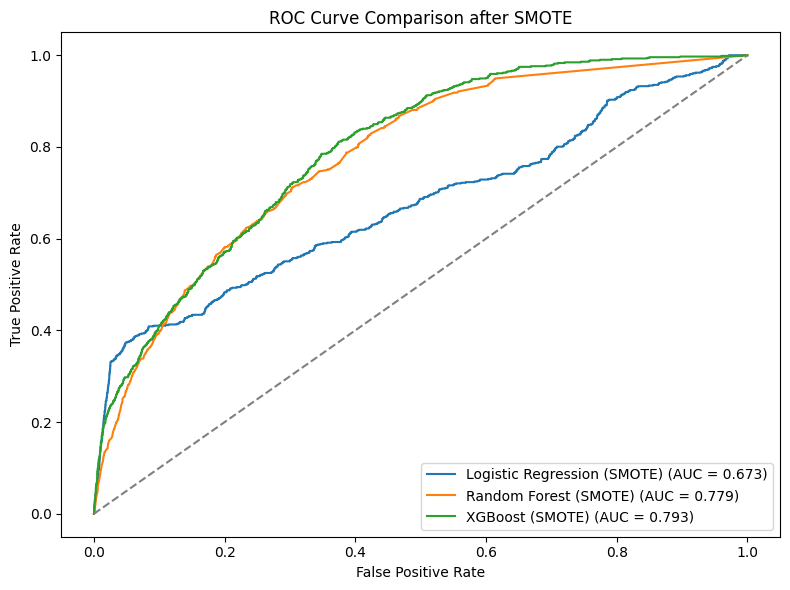

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))

for name, (y_pred, y_prob) in models.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve Comparison after SMOTE")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()


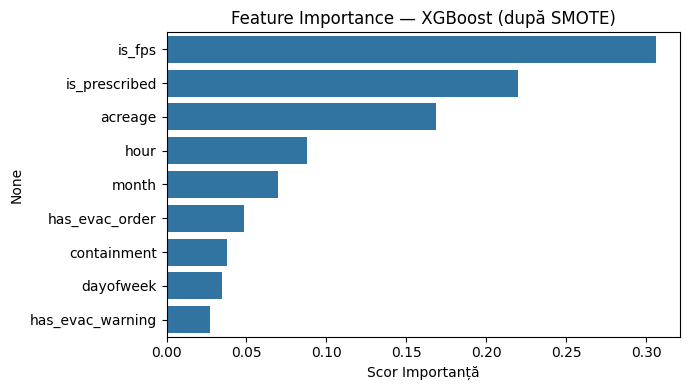

In [ ]:
# Numele coloanelor
feature_names = X.columns if isinstance(X, pd.DataFrame) else features

# Extragem importanța
xgb_importance = pd.Series(xgb.feature_importances_, index=feature_names).sort_values(ascending=False)

# Vizualizare
plt.figure(figsize=(7,4))
sns.barplot(x=xgb_importance.values, y=xgb_importance.index)
plt.title("Feature Importance — XGBoost (după SMOTE)")
plt.xlabel("Scor Importanță")
plt.tight_layout()
plt.show()


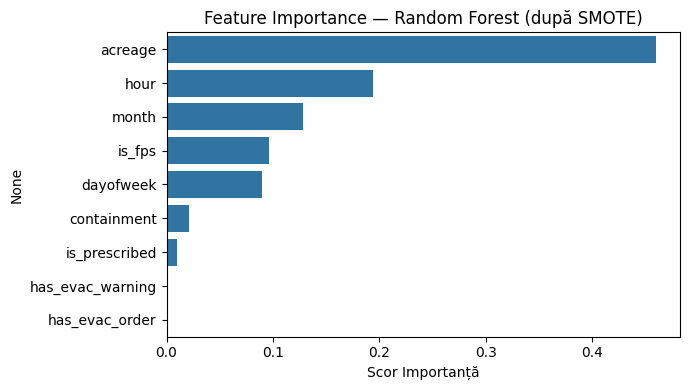

In [ ]:
# Extragem importanța
rf_importance = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)

# Vizualizare
plt.figure(figsize=(7,4))
sns.barplot(x=rf_importance.values, y=rf_importance.index)
plt.title("Feature Importance — Random Forest (după SMOTE)")
plt.xlabel("Scor Importanță")
plt.tight_layout()
plt.show()
